In [3]:
# Import Libraries
import causalpy as cp
import pandas as pd
from datetime import datetime
import scipy as stats
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import arviz as az 

# Load Data
data = pd.read_csv('test-data.csv')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
#Helper function to filter data using criterias

def clean_data(data):
    val = 'sessions'
    cat = 'country'
    data = data.assign(Time=lambda x:pd.to_datetime(x['date'],format = "%Y-%m-%d")).set_index('Time')
    data = data.dropna()
    data = data.pivot(columns=cat,values=val)
    for col in data:
        filled = data[col].isna().value_counts().to_dict()[False]
        if (filled/len(data)) < 0.7:
            data=data.drop(col,axis=1)
    data = data.fillna(0)
    return data

# Returns a subset of data that is of a certain level of correlation and higher
def corr_filter(data,country,correlation):
    new_data = data.corr()[country]
    corr_data = new_data[new_data>correlation]
    return data[corr_data.index]


# Perform Kmeans and return the clusters
def group(cleaned_data):
    cluster0 = []
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    cluster5 = []
    cluster6 = []
    cluster7 = []
    kmeans = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(cleaned_data.T)

    for i in range(len(kmeans.labels_)):
        clus = kmeans.labels_[i]
        if clus == 0 :
            cluster0.append(cleaned_data.iloc[:,i].name)
        elif clus == 1:
            cluster1.append(cleaned_data.iloc[:,i].name)
        elif clus == 2:
            cluster2.append(cleaned_data.iloc[:,i].name)
        elif clus == 3:
            cluster3.append(cleaned_data.iloc[:,i].name)
        elif clus == 4:
            cluster4.append(cleaned_data.iloc[:,i].name)
        elif clus == 5:
            cluster5.append(cleaned_data.iloc[:,i].name)
        elif clus == 6:
            cluster6.append(cleaned_data.iloc[:,i].name)
        elif clus == 7:
            cluster7.append(cleaned_data.iloc[:,i].name)
    return cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7

# Get equal clusters of user defined size

def get_even_clusters(cleaned_data, cluster_size):
    n_clusters = int(np.ceil(len(cleaned_data.T)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(cleaned_data.T)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, cleaned_data.T.shape[-1]).repeat(cluster_size, 1).reshape(-1, cleaned_data.T.shape[-1])
    distance_matrix = cdist(cleaned_data.T, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    
    
    cluster0 = []
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    cluster5 = []
    cluster6 = []
    cluster7 = []

    for i in range(len(kmeans.labels_)):
        clus = kmeans.labels_[i]
        if clus == 0 :
            cluster0.append(cleaned_data.iloc[:,i].name)
        elif clus == 1:
            cluster1.append(cleaned_data.iloc[:,i].name)
        elif clus == 2:
            cluster2.append(cleaned_data.iloc[:,i].name)
        elif clus == 3:
            cluster3.append(cleaned_data.iloc[:,i].name)
        elif clus == 4:
            cluster4.append(cleaned_data.iloc[:,i].name)
        elif clus == 5:
            cluster5.append(cleaned_data.iloc[:,i].name)
        elif clus == 6:
            cluster6.append(cleaned_data.iloc[:,i].name)
        elif clus == 7:
            cluster7.append(cleaned_data.iloc[:,i].name)
    return cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7


# Format the clusters into single, pair and groups
def formatGroup(grouped_data):
    for cluster in grouped_data:
        if len(cluster) == 1:
            print(f"Single Cluster {cluster}")
        elif len(cluster) == 2:
            print(f"Pair Cluster {cluster}")
        elif len(cluster) <= 10:
            print(f"Cluster:{cluster}")
        else:
            print(f"Large Cluster:{cluster}")
        
        
# Get cluster with desired country

def getCluster(grouped_data,country):
    for cluster in grouped_data:
        if country in cluster:
            return cluster

        
# Calculate the dynamic time warping scores (similarity between time series adjusted for shifts in x & y axis)
def calcdtw(col1,col2):
    sig1 = zscore(col1)
    sig2 = zscore(col2)
    distance, path = fastdtw(sig1, sig2, dist=euclidean)
    return distance

# Get a dictionary of dtw scores for each pair of columns in the dataframe
def getdtw(data):
    scores = {}
    for i in range(len(data.columns)):
        name1 = data.iloc[:,i].name
        col1 = data.iloc[:,i].reset_index().drop('Time',axis=1)
        for j in range(1+i,len(data.columns)):
            name2 = data.iloc[:,j].name
            col2 = data.iloc[:,j].reset_index().drop('Time',axis=1)
            res = calcdtw(col1,col2)
            scores[(name1,name2)] = res
    return scores


def lowestdtw(scores,country):
    lowestk = ()
    lowest = 0
    for k,v in scores.items():
        if country in k:
            if lowest == 0:
                lowestk = k
                lowest = v
            elif v<lowest:
                lowestk = k
                lowest = v
    return lowestk,lowest


In [5]:
# Automated Pipeline

def geolift(data,target,treatmentDate):
    # Remove empty and irrelevant data
    step1 = clean_data(data)
    # Filter for highly correlated 
    step2 = corr_filter(step1,target,0.9)
    # Get clusters
    clus = getCluster(get_even_clusters(step2,5),target)
    print(clus)
    # Get dtw scores
    dtw_scores = getdtw(step2)
    pair = lowestdtw(dtw_scores,target)[0]
    
    #Perform experiment using cluster
    exp1 = step2[clus] 
    #Set up experiment
    treatment_time = pd.to_datetime(treatmentDate)
    
    # Get results of experiment using clusters
    # edit formulas
    rest = ""
    clus.remove(target)
    for unit in clus:
        rest = " + " + unit
    formula = target + " ~ 0" + rest

    result = cp.pymc_experiments.SyntheticControl(
        exp1,
        treatment_time,
        formula=formula,
        model=cp.pymc_models.WeightedSumFitter(
            sample_kwargs={"target_accept": 0.95, "random_seed": 42}
        ),
    )
    
            
    # get index of the final time point
    index = result.post_impact_cumulative.obs_ind.max()
    # grab the posterior distribution of the cumulative impact at this final time point
    last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
    print(az.summary(last_cumulative_estimate, kind="stats"))
    
    fig, ax = result.plot(plot_predictors=False)

    # formatting
    ax[2].tick_params(axis="x", labelrotation=-90)
    for i in [0, 1, 2]:
        ax[i].set(ylabel="Sessions")
        
    #Perform experiment using dtw
    exp2 = step2[list(pair)] 
    format = "%Y-%m-%d"
    treatment_time2 = datetime.strptime(treatmentDate,format)
    exp2.index = (exp2.index - treatment_time).days
    treatment_time2 = 0
    
    exp2.reset_index(level=0, inplace=True)
    df_long = pd.melt(
        exp2,
        id_vars=["Time"],
        value_vars=list(pair),
        var_name="country",
        value_name="sessions",
    ).sort_values("Time")
    
    # We also need to create a column called `unit` which labels each distinct
    # unit. In our case we just have two treatment units (each district). So
    # we can build a `unit` column from `district`.
    df_long["unit"] = df_long["country"]

    # We also need to create a `post_treatment` column to define times after
    # the intervention.
    df_long["post_treatment"] = df_long.Time >= treatment_time2

    # Dummy coding for district
    df_long['country'] = np.where(df_long['country']==target,1,0)
    
    result2 = cp.pymc_experiments.DifferenceInDifferences(
        df_long,
        formula="sessions ~ 1 + Time + country*post_treatment",
        time_variable_name="Time",
        group_variable_name="country",
        model=cp.pymc_models.LinearRegression(
            sample_kwargs={"target_accept": 0.95, "random_seed": 42}
        ),
    )
    
    # Visualize results
    fig, ax = result2.plot(round_to=3)
    

C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


['CA', 'CH', 'NL']


C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use

      mean   sd   hdi_3%  hdi_97%
x  70046.0  0.0  70046.0  70046.0


C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Sampling: [y_hat]
C:\Users\turtl\anaconda3\envs\myenv\Lib\site-packages\pymc\model\core.py:560: FutureWarning: Model.model property is d

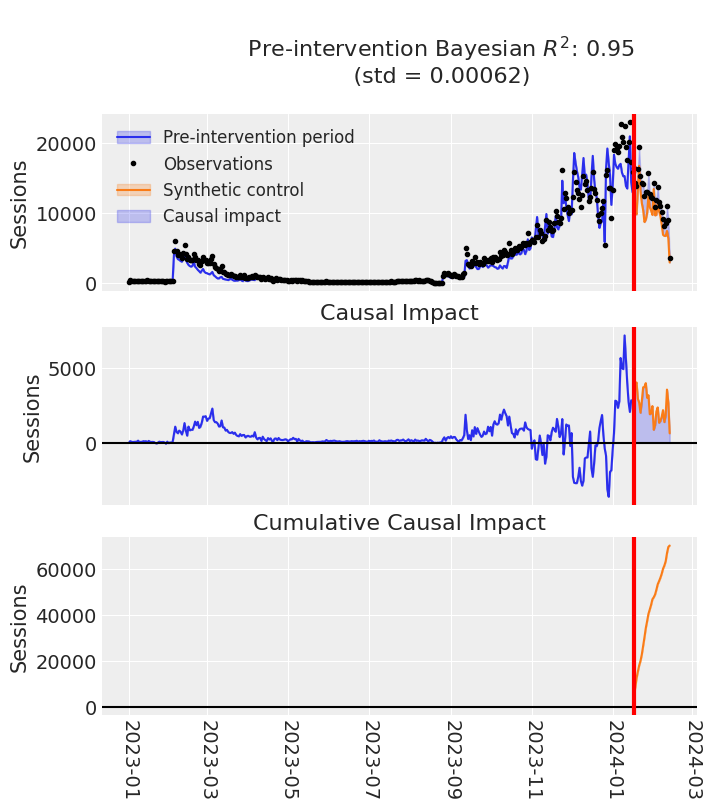

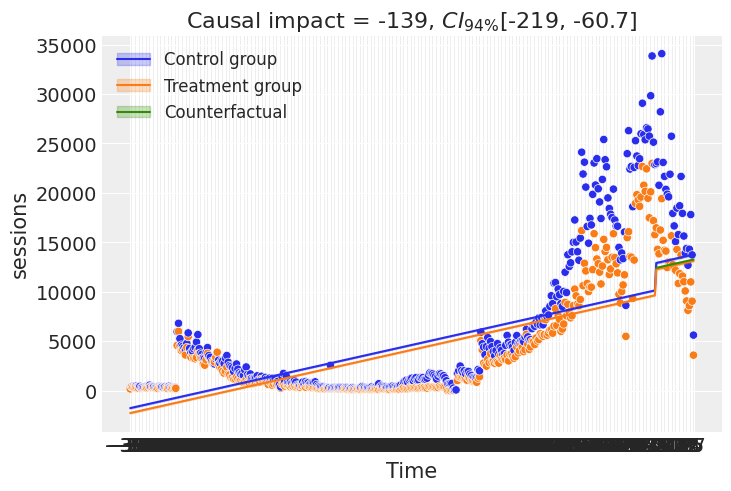

In [6]:
geolift(data,'NL','2024-01-17')